# Gaussian Mixture Model vs. KMeans with Fashion-MNIST

Quentin Le Roux -- MSc Data Science \& AI 1

<hr>

## 0. Introduction

### 0.1 Table of Content

- **0. Introduction**
    - Table of Content
    - Task Description
    - Importing Modules
    
    
- **1. Importing the Dataset**
    - Importing the dataset
    - Data Pre-Processing


- **2. Implementation of KMeans**
    - Simple Implementation From Scratch
    - Implementation using SciKit-Learn
    - Observations
    
    
- **3. Implementation of GMM**
    - Simple Implementation From Scratch
    - Implementation using SciKit-Learn
    - Observations
    
    
- **4. Comparing the results of both KMeans and GMM**
    - 5.1. Comparison
    - 5.2.  Other Explorations: Trying out MaxPooling and a Sobel Filter instead of PCA
    

- **5. Exploring the parameters of GMM**


- **6. References used in this exercise**

### 0.2 Task Description

**Clustering** is abour grouping similar objects together. It is a type of **unsupervised learning**: the generic application of machine learning to bunch data together based on similar criteria. Unsupervised learning algorithms will work to partition data into smaller groups of similar objects while trying to maximize the differences between each group. **KMeans** and **Gaussian Mixture Models** are examples of clustering algorithms. 

The goal of this notebook is to compare the applications of the KMeans and GMM algorithms on the Fashion-MNIST dataset. Afterward, we will explore the impacts of changing the GMM's parameters using a gridsearch-style method.

### 0.3 Importing Modules

In [1]:
from keras.datasets import fashion_mnist

from itertools import cycle
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd

from scipy import ndimage
from scipy.ndimage.filters import maximum_filter

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import decomposition
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 1. Importing the dataset: Fashion-MNIST

### 1.1. Importing the dataset

Our first step is to import our dataset: [Fashion-MNIST](https://keras.io/api/datasets/fashion_mnist/). The copyright for Fashion-MNIST is held by Zalando SE and Fashion-MNIST is licensed under the MIT license.

Fashion-MNIST is a dataset of Zalando's article images. It consists of a **training set of 60,000 examples** and a **test set of 10,000 examples**. Each example is a 28x28 grayscale image, associated with a **label from 10 classes**. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

<u>Image shape:</u>

Each image is **28 pixels in height and 28 pixels in width, for a total of 784 pixels in total**. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

<u>Labels:</u>

Each training and test example is assigned to one of the following labels:

- 0 -- T-shirt/top
- 1 -- Trouser
- 2 -- Pullover
- 3 -- Dress
- 4 -- Coat
- 5 -- Sandal
- 6 -- Shirt
- 7 -- Sneaker
- 8 -- Bag
- 9 -- Ankle boot

In [2]:
# We import the dataset's training and test sets and check the shape of the 
# resulting arrays.

(x_train_origin, y_train), (x_test_origin, y_test) = fashion_mnist.load_data()

labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", 
              "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(f"Shape of x_train_origin: {x_train_origin.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test_origin: {x_test_origin.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train_origin: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test_origin: (10000, 28, 28)
Shape of y_test: (10000,)


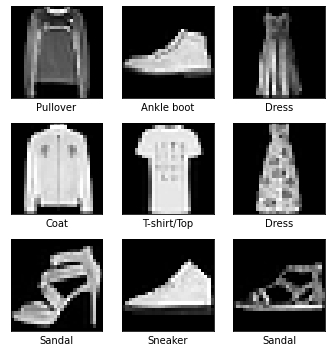

In [3]:
# We sample some images to check the content of the dataset

length = 3
plt.figure(figsize=(5, 5)) 
for i in range(length * length):
    temp = rd.randint(0, len(x_train_origin)+1)
    image = x_train_origin[temp] 
    plt.subplot(length, length, i+1)       
    plt.imshow(image, cmap='gray')  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labelNames[y_train[temp]])
    plt.tight_layout()   
plt.show()

To preprocess the data, we must standardardize the whole dataset. As such, we temporarily merge train and test sets.

In [4]:
# We concatenate our training and test sets to perform our pre-processing

X = np.concatenate((x_train_origin, x_test_origin))
print(f"Shape of X: {X.shape}")

Shape of X: (70000, 28, 28)


### 1.2. Data Preprocessing

Data Pre-Processing is an important first step towards machine learning. Below, we will go through three different pre-processing steps.

**Normalization**: Each item in the dataset is a grayscale picture (i.e. 1 channel instead of 3 for RGB) where each pixel is represented by an integer value between $0$ and $255$. We need to rescale each pixel value to the [0,1] range, i.e., normalize them. This rescaling is done by dividing each pixel value by 255.

In [5]:
# Before
print(f"One pixel before normalization: {X[0][5][15]}")

# Normalization
X = X / 255.

# After
print(f"One pixel after normalization: {X[0][5][15]}")

One pixel before normalization: 204
One pixel after normalization: 0.8


**Flattening**: Since each image is a 2-dimensional picture of 28 pixels by 28 pixels, we must reshape our data so it can be fed into our models. To do so, we reshape our image into a single dimension of size 28\*28, i.e. 784.

In [6]:
# Flattening

X = X.reshape(len(X), 784)

print(f"Shape of X: {X.shape}")

Shape of X: (70000, 784)


**Feature Extraction**: Principal Component Analysis for dimensionality reduction (or PCA for short) is used to reduce the complexity of a model, avoid overfitting, and visualize high dimensional data. It is an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction. 

We aim to use PCA reduction to reduce the complexity of the high dimensional (784) Fashion-MNIST dataset. To do so, we compute the cumulative explained variance with a number of components from 0 to 784. With this analysis, we will be able to choose a number of components that balances between explaining a high variance within the dataset and realizing a strong reduction in complexity.

In [7]:
# Feature extraction

pca = decomposition.PCA()
X_fe = StandardScaler().fit_transform(X)

pca.n_components = 784
X_fe = pca.fit_transform(X_fe)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

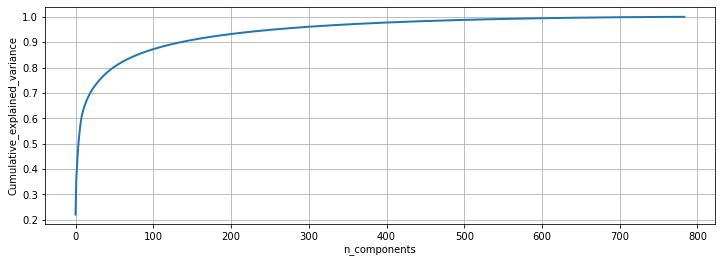

In [8]:
# We plot the PCA spectrum

plt.figure(1, figsize=(12, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis("tight")
plt.grid()
plt.xlabel("n_components")
plt.ylabel("Cumulative_explained_variance")
plt.show()

We find that 90%+ of the variance is explained once we reach above 120 components. As such we settled on a dimensionality reduction to 121 components, which provides us an easy 11\*11 representation.

In [9]:
# We reduce our number of components to 121

pca = decomposition.PCA(n_components=121)
X_fe = StandardScaler().fit_transform(X)
X = pca.fit_transform(X_fe)

print(f"Shape of x_train_processed: {X.shape}")

Shape of x_train_processed: (70000, 121)


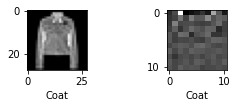

In [10]:
# We sample 1 image from the training set and pair it with its 11*11-components 
# representation

for i in rd.sample(range(60000),1):
    i1 = x_train_origin[i] 
    i2 = X[i].reshape(11,11)
    plt.subplot(length, length, 1)       
    plt.imshow(i1, cmap='gray')  
    plt.xlabel(labelNames[y_train[i]])  
    plt.subplot(length, length, 2)       
    plt.imshow(i2, cmap='gray')  
    plt.xlabel(labelNames[y_train[i]])
    plt.tight_layout()   
    plt.show()

Finally, we split our dataset back into a train and test set.

In [11]:
# We retrieve our train and test sets

x_train = X[:60000]
x_test = X[60000:]

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (60000, 121)
Shape of x_test: (10000, 121)


## 2. Implementation of KMeans

KMeans is an **unsupervised clustering algorithm** that tries to cluster the elements of a given dataset into a *k* number of clusters. It is a **centroid-based clustering**, i.e., we create k centroids, find the centres of each cluster and then assign each data point to the closest centre. This is the approach that the k-means clustering algorithm uses. 

As such, it is an **iterative algorithm** meaning that we repeat multiple steps making progress each time. In more details, it proceeds as follow:

```
0. Choose a value for k
1. Selects k random points from the dataset as starting cluster centers (i.e. centroids)
2. For all data point in the dataset:
    2.1 calculates the distance (such as the euclidian distance (1)) between the point 
        and the clusters
    2.2 assigns the point to the closest center (2)
3. Update each cluster center by taking the average of the points within the cluster
4. Repeat steps 2 and 3 until convergence, i.e., when the centers do not change 
   meaningfully
```
$$given\,\,x_i \in \mathbb{R}^m\,\,\forall i, k \in [1, ..., n]$$

$$d(x_i,center_k)=\sqrt{\underset{j=1}{\overset{m}{\sum}}(x_{i,j}-center_{k,j})^2}\,\,\forall i, k \in [1, ..., n] \quad (1)$$

$$cluster(x_i) = argmin\,\,d(x_i,center_k)\,\,\forall i, k \in [1, ..., n] \quad (2)$$

**Performance evaluation** for the KMeans algorithm can be done by calculating the sum of squared differences betweent our data points and centroids:

$$\underset{i=0}{\overset{n}{\sum}}(X_i-\bar{X})^2$$

With $X_i$ a data point and $\bar{X}$ the centroid that point belongs to.

### 2.1. Simple Implementation From Scratch

We now have an idea about how the algorithm works. We can thus implement a simple version of it to see how it works. Using the ``make_blobs`` function from the SciKit-Learn library we implement a KMeans using the euclidian distance metric.

In [12]:
def generate_dataset(number_of_points):
    """
    Generates a dataset of 2d coordinates (x, y), with x and y random values 
    between 0 and 99.
    The set is generated with a random number of centers between 2 and 9.
    """
    X, _ = make_blobs(n_samples=number_of_points, 
                      centers=rd.randint(2,10), 
                      n_features=2, 
                      random_state=0)
    return X

def compare_dict(dict1, dict2):
    """
    Checks if two dictionary are identical.
    """
    for key in dict1.keys():
        if not np.array_equal(dict1[key], dict2[key]): return False
    return True

def euclidian_distance(p1, p2):
    """
    Calculates the euclidian distance between two points in the R² space.
    """
    distance = 0
    for idx, item in enumerate(p1): 
        distance += (item - p2[idx]) ** 2
    return math.sqrt(distance)

In [13]:
class k_means():
    def __init__(self, nb_of_data_points, k=2):
        """
        Initializes the k_means class.
        """
        self.data = generate_dataset(nb_of_data_points)
        self.k = k
        self.iterated = 0
        self.colors = cycle(["g","r","b","c","m","y"])
        
        # Generates an empty dictionary to store each step's centroids
        self.model_centroids = {}
        
        # Generates an empty dictionary to store each step's classification
        self.model_classifications = {}
    
    
    def fit(self, max_iterations=100):
        """
        Fits the model with a maximum number of iterations by default of 100.
        """
        self.iterated = 0
        
        # Selects the initial k centroids
        centroids = rd.sample(list(self.data), 2)
        
        # Iterative steps to fit the model
        for iteration in range(max_iterations):
            print(f"Epoch {iteration}")
            
            # Generates an empty dictionary to store the iteration's 
            # classification
            step_classification = {}
            for k in range(self.k): step_classification[k] = []
            
            # Calculates the euclidian distance between each data point 
            # and each centroid
            # Records the nearest centroid
            for point in self.data:
                distances = list(map(lambda x: euclidian_distance(point, x), 
                                     centroids))
                argmin = min(range(len(distances)), 
                             key=distances.__getitem__)
                step_classification[argmin].append(point)
            
            # Records the state of the model after the iteration
            self.model_centroids[iteration] = centroids
            self.model_classifications[iteration] = step_classification
            
            # If no change has been identified between this iteration and the 
            # last, the model will stop.
            if len(self.model_classifications)>1:
                if compare_dict(self.model_classifications[iteration],
                                self.model_classifications[iteration-1]):
                    self.iterated = iteration
                    print("No significant change has been achieved during" +\ 
                          f"epoch {self.iterated}. "+\
                          "Model is considered fitted.")
                    break
            
            # Updates the centroids
            centroids = []
            for classification in step_classification.values():
                if classification == []: centroids.append(np.zeros(3))
                else: centroids.append(np.mean(classification, axis=0))
       
    
    def plot_data(self):
        """
        Plots the distribution of the data.
        """
        # Declares the plot
        plt.figure(figsize=(6,6))

        # Plots the data without colors if the dataset was not iterated over.
        if self.model_centroids == {} or self.iterated == 0:
            plt.scatter(self.data[:,0],self.data[:,1])

        else:
            # Plots the centroids first
            for centroid in self.model_centroids[self.iterated]:
                plt.scatter(centroid[0], centroid[1], 
                            marker="o", color="k", s=50, linewidths=5)

            # plots the data points
            for classification in self.model_classifications[self.iterated].values():
                color = next(self.colors)
                for feature in classification:
                    plt.scatter(feature[0], feature[1], 
                                marker='x', color=color, s=20, linewidths=2)
        plt.show()

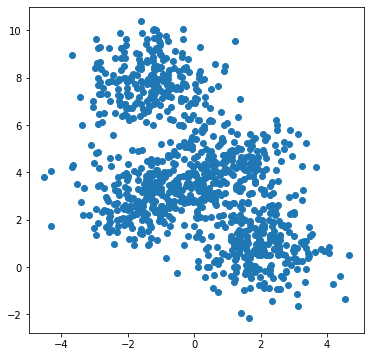

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
No significant change has been achieved during epoch 11. Model is considered fitted.


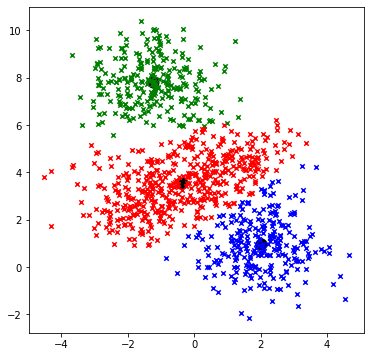

In [14]:
# Example of a KMeans on a randomly generated 1000-point dataset with 
# three clusters

model = k_means(1000, 3)
model.plot_data()
model.fit()
model.plot_data()

We now see how a KMeans algorithm works.

### 2.2. Implementation using SciKit-Learn

As the simple from scratch KMeans works, and now that we have a better grasp on the different steps involved to fit the model, we can implement one using the SciKit-Learn library. 

As such, we go back to our Fashion-MNIST dataset.

1. We set our hyperparameters:

In [15]:
# Number of clusters we want to implement our model with
# We set it to match the number of classes in the Fashion-MNIST dataset
n_clusters = 10

# We choose a k-means++ initialization, a scikit-learn initialization 
# method that selects initial cluster centers in a 'smart way'
# it is supposed to speed up the convergence
init = "k-means++"

# We indicate that our KMeans algorithm we be run with 50 different
# centroid seeds and our final output will be the one with the 
# best results out of 50
n_init=50

# We indicate we want the model will not go over 100 iterations
max_iter = 100

2. We declare our model:

In [16]:
model = KMeans(n_clusters=n_clusters, 
               init=init,
               n_init=n_init,
               max_iter=max_iter, 
               verbose=0, 
               random_state=0).fit(x_train)

3. We predict labels on our test dataset using the resulting trained model:

In [17]:
label_predictions = model.predict(x_test)

4. We output our resulting metrics:

<hr>
    
**Remark**:

- The **homogeneity score** is a metric that checks whether the resulting clusters contain only data points which are members of a single class. It is *independent of the absolute values of the predicted labels*. The resulting score yields a real value between 0 and 1 with 1 standing for perfect homogeneous labeling.

- The **v-measure score** takes the homogeneity score and another underlying one (the completeness score, which measures whether all data points that belong to the same class are clustered within the same cluster) and provides a weighted measure: $\frac{(1+\beta).hc}{\beta.h+c}$ with $\beta$ a factor that favors either the homogeneity or the completeness. The value of this evaluation metric is that it is independent of the number of class lavels, clusters, and of the size of the data. The resulting score yields a real value between 0 and 1 with 1 standing for perfectly complete labeling.
   
- The **silhouette** score measures the overlapping of clusters over all the samples. The resulting score yields a real value between -1 and 1 with values near 0 indicating overlapping clusters, and a negative value indicating that a sample has been assigned to the wrong cluster.

<hr>

In [18]:
kmeans_h_score = homogeneity_score(y_test, label_predictions)
kmeans_v_score = v_measure_score(y_test, label_predictions)
kmeans_s_score = silhouette_score(x_test, label_predictions)

print(kmeans_h_score, kmeans_v_score, kmeans_s_score)

0.4930005331280772 0.5052442593457442 0.15585513066658788


<u>See our detailed observations below.</u>

### 2.3. Observations

We visualize the resulting clustering on our test set.

Each row presents a trio of pictures that were assigned to the same cluster.

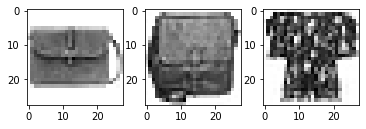

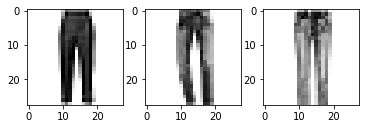

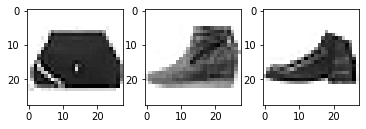

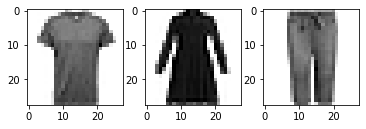

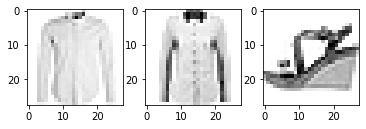

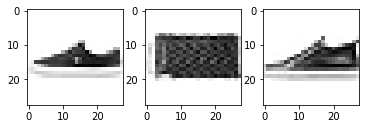

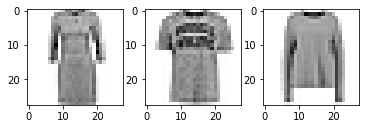

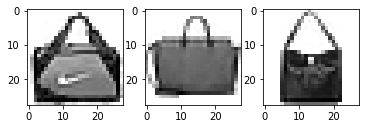

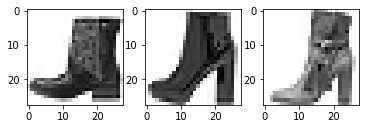

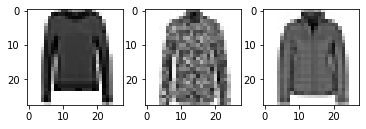

In [19]:
label_number = 10

cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(label_predictions):
    for n in range(label_number):
        if label == n: 
            cluster_index[n].append(i)
        else: 
            continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(6,6));
    clust = j
    num = 10
    for i in range(1,4):
        plt.subplot(3, 3, i)
        plt.imshow(x_test_origin[cluster_index[clust][i+20]], 
                   cmap = plt.cm.binary);

plt.show()

To provide a better view of what is happening, we visualize the repartition of the test set's items between each clusters.

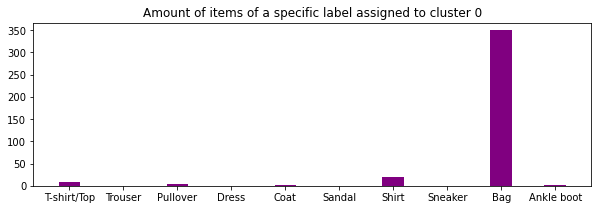

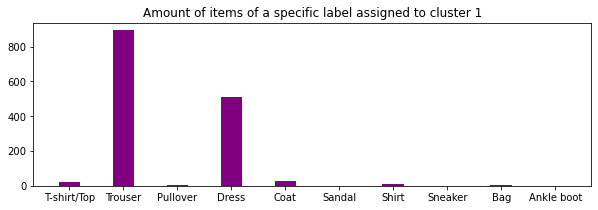

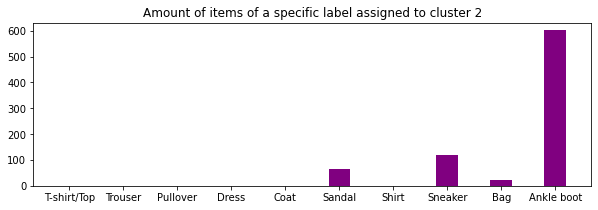

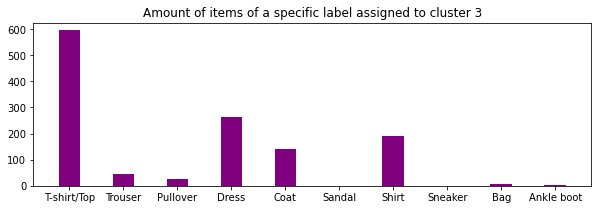

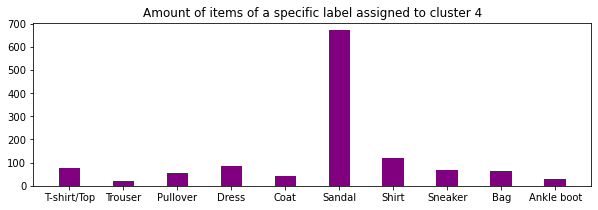

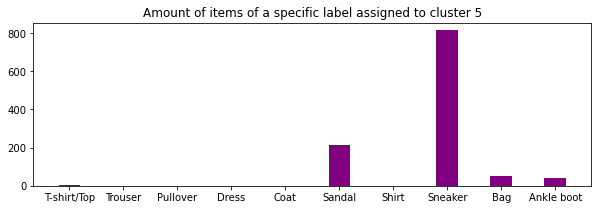

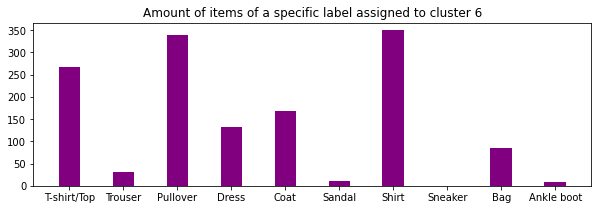

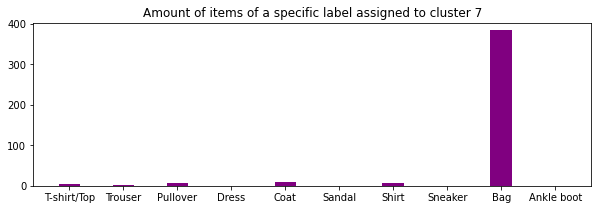

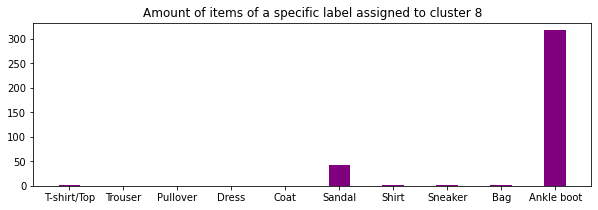

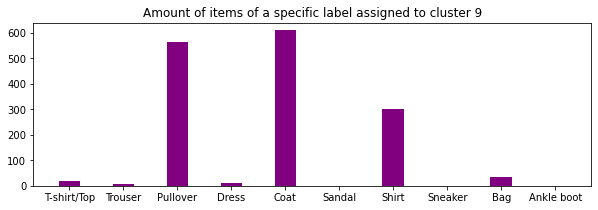

In [20]:
clusters={}
for i in range(10):
    clusters[i]=[0]*10

for index, item in enumerate(label_predictions):
    clusters[item][y_test[index]] += 1

for i in range(len(clusters)):
    fig = plt.figure(figsize=(10,3))
    plt.bar(labelNames, clusters[i], color="purple", width=0.4)
    plt.title(f"Amount of items of a specific label assigned to cluster {i}")
    plt.show()

Finally, we look into reducing the dimensionality of our dataset to 3, and produce a 3-d visualization of the clustering. 

The goal is to see if we can find patterns.

In [21]:
# Dimensionality reduction to 3 dimensions

pca = decomposition.PCA(n_components = 3)
x_test_viz = StandardScaler().fit_transform(x_test)
x_test_viz = pca.fit_transform(x_test_viz)

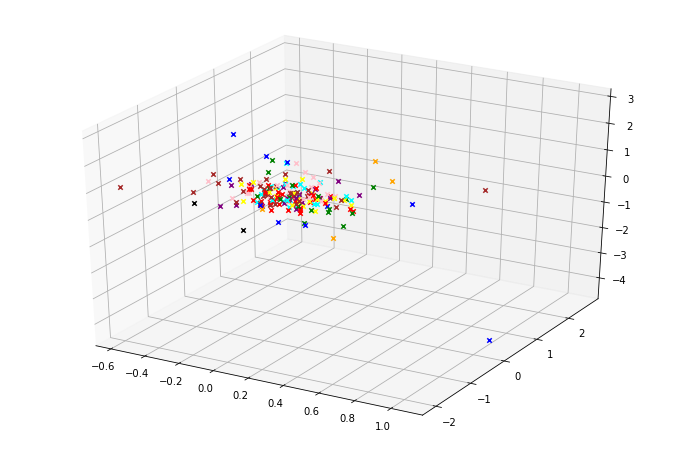

In [22]:
colors = ["blue","red","green","pink","purple","cyan",
          "yellow","orange","black","brown"]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for index, item in enumerate(x_test_viz[:200]):
    ax.scatter(item[0], 
               item[1], 
               item[2], 
               marker="x", 
               color = colors[label_predictions[index]])

plt.show()

**<u>Summary of observations:</u>**

<hr><span style="color:green">The above visualizations highlight a few key behaviors:
    
> 1. KMeans is **quite able to distinguish bags** (clusters 0 and 7), **ankle boots** (clusters 2 and 8), and **sandals** and **sneakers** (clusters 4 and 5) from the rest of the dataset
>
> 2. KMeans **struggles identifying trousers from dresses**, pooling them in the same cluster (cluster 1)
>
> 3. KMeans **struggles identifying all top clothes from each other** (clusters 3, 6, and 9)
    
We obtained a **homogeneity score of c. 0.49**, a **v-measure score of c. 0.51**, and a **silhouette score of c. 0.16**.
    
**As such, we can confidently say that the KMeans algorithm is able to distinguish larger granularities of clothes (top, bag, shoes) than the ones provided by the Fashion-MNIST dataset.**

<hr>

## 3. Implementation of GMM

Gaussian Mixture Models, or GMM, are a class of **unsupervised machine learning algorithms** that try to extract normally distributed subpopulations from an overall population. Like KMeans, GMM are a type of unsupervised machine learning.

A GMM is parametrized by two types of values: the **mixture component weights**, and the **component means and variances**.

Given $k$ the number of component $C_k$ of a GMM, each component has a mean $\mu_k$ and a variance $\sigma^2_k$ (for the univariate case, otherwise $\mu$ and $\sigma$ are vectors). The mixture component wieghts are defined as $\phi_k$ for a component $C_k$, with the constraint that $\overset{K}{\underset{i=1}{\sum}}\phi_i=1$ so that the total probability distribution normalizes to 1.

#### One-Dimensional Model

$$p(x) = \underset{i=1}{\overset{K}{\sum}}\phi_i.\mathcal{N}(x|\mu_i, \sigma^2_i)$$

$$\mathcal{N}(x|\mu_i, \sigma^2_i) = \frac{1}{\sigma_i.\sqrt{2.\pi}}.exp(\frac{-(x-\mu_i)^2}{2.\sigma_i^2})$$

$$\underset{i=1}{\overset{K}{\sum}}\phi_i=1$$

#### Multi-Dimensional Model

$$p(x) = \underset{i=1}{\overset{K}{\sum}}\phi_i.\mathcal{N}(\overset{\rightarrow}{x}|\overset{\rightarrow}{\mu_i}, \sum_i)$$

$$\mathcal{N}(\overset{\rightarrow}{x}|\overset{\rightarrow}{\mu_i}, \sum_i) = \frac{1}{\sqrt{(2.\pi)^K.|\sum_i|}}.exp(-\frac{1}{2}.(\overset{\rightarrow}{x}-\overset{\rightarrow}{\mu_i})^T).\sum_i^{-1}.(\overset{\rightarrow}{x}-\overset{\rightarrow}{\mu_i}))$$

$$\underset{i=1}{\overset{K}{\sum}}\phi_i=1$$

**Expectation Maximization** or EM is the most common technique to estimate the mixture model's parameters when the number of components $k$ is known. EM is an **iterative numerical technique for maximum likelihood estimation** and **is guaranteed to approach a local maximum** or saddle point.

#### Expectation Maximization

As it is an iterative algorithm, it proceeds as follow:

```
1. Initialization step 1: We randomly assign k samples without replacement from the 
   dataset to k component mean estimates
2. Initialization step 2: We set all the component variance estimates to the sample 
   variance (1)
3. Initialization step 3: We set all component distribution prior estimates to the 
   uniform distribution (2)
4. E(xpectation)-Step: We calculate the probability that each data point is generated 
   by a component C (3)
5. M(aximization)-Step: We maximize the expectations calculated in the E step with 
   respect to the model parameters. The model parameters are then updated (4)
6. The steps 4 and 5 are repeated until convergence
```

$$\sigma^2_k = \underset{i=1}{\overset{N}{\sum}}(x_i - \bar{x})^2 \quad (1)$$

$$\bar{x} = \frac{1}{N}\underset{i=1}{\overset{N}{\sum}}x_i$$

$$\phi_i = \frac{1}{K} \quad (2)$$

$$\forall i,k \quad \hat{\gamma}_{i,k}=\frac{\hat{\phi}_k.\mathcal{N}(x_i|\hat{\mu}_k, \hat{\sigma}^2_k)}{\underset{j=1}{\overset{K}{\sum}}\hat{\phi}_j.\mathcal{N}(x_i|\hat{\mu}_j, \hat{\sigma}^2_j)}=p(C_k|x_i,\hat{\phi},\hat{\mu},\hat{\sigma}^2) \quad (3)$$

$$\forall k \quad \hat{\phi}_k = \underset{i=1}{\overset{N}{\sum}}\frac{\hat{\gamma}_{i,k}}{N} \quad (4.1)$$

$$\forall k \quad \hat{\mu}_k=\frac{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}.x_i}{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}} \quad (4.2)$$

$$\forall k \quad \hat{\sigma}^2_k=\frac{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}.(x_i-\hat{\mu}_k)^2}{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}} \quad (4.3)$$

### 3.1. Simple Implementation From Scratch

We now have an idea about how the algorithm works. We can thus implement a simple version of it to see how it works.

In [23]:
class GMM():
    def __init__(self, nb_of_data_points, k=2):
        """
        Initializes the GMM class.
        """
        self.data = generate_dataset(nb_of_data_points)
        self.k = k
        self.colors = ["g","r","b","c","m","y"]
        self.phi = [1/self.k for _ in range(self.k)]
        self.cluster_names = list(range(10))
        self.clusters = []
    
    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        """
        Formula of the multivariate normal distribution.
        """
        first_element = ((2*np.pi)**len(X) * np.linalg.det(covariance_matrix))**(-1/2)
        exponential = np.exp(-1/2*np.dot(np.dot((X-mean_vector), 
                                                np.linalg.inv(covariance_matrix)).T, 
                                         (X-mean_vector)))
        return first_element * exponential    
    
    def fit(self, max_iterations=100):
        """
        Fits the model with a maximum number of iterations by default of 100.
        """
        # Splits the data in k subsets
        X = np.array_split(self.data, self.k)
        
        # Initializes the computation of the mean vector and the 
        # covariance matrix
        self.mean_vector = [np.mean(x, axis=0) for x in X]
        self.covariance_matrices = [np.cov(x.T) for x in X]
        
        for iteration in range(max_iterations):
            if iteration %10 == 0: print(f"Epoch {iteration}")
            
            # E-Step
            
            # Calculates the gammas
            self.p = np.zeros((len(self.data), self.k)) #, dtype=object)
            
            # Calculates the phi matrix
            for n in range(len(self.data)):
                for k in range(self.k):
                    self.p[n][k] = self.phi[k] * self.multivariate_normal(
                        self.data[n],
                        self.mean_vector[k],
                        self.covariance_matrices[k]
                    )
                    self.p[n][k] /= sum([
                        self.phi[j]*self.multivariate_normal(
                            self.data[n], 
                            self.mean_vector[j], 
                            self.covariance_matrices[j]
                        ) 
                        for j in range(self.k)
                    ])
            N = np.sum(self.p, axis = 0)            
            
            # M-Step
            
            # Initializes the mean vector as a zero vector
            self.mean_vector = np.zeros((self.k, len(self.data[0])))
            
            # Updates the mean vector
            for k in range(self.k):
                for n in range(len(self.data)):
                    self.mean_vector[k] += self.p[n][k] * self.data[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] 
                                for k in range(self.k)]
            
            # Initializes the list of the covariance matrices
            self.covariance_matrixes = [np.zeros((len(self.data[0]), 
                                                  len(self.data[0]))) 
                                        for k in range(self.k)]
            
            # Updates the covariance matrices
            for k in range(self.k):
                self.covariance_matrices[k] = np.cov(self.data.T, 
                                                     aweights=(self.p[:,k]), 
                                                     ddof=0)
            self.covariance_matrices = [1/N[k]*self.covariance_matrices[k] 
                                        for k in range(self.k)]
            
            # Updates the phi list
            self.phi = [N[k]/len(self.data) for k in range(self.k)]     
    
    def predict(self):
        """
        Predicts the data.
        """
        probabilities = []
        for n in range(len(self.data)):
            probabilities.append([self.multivariate_normal(
                self.data[n], 
                self.mean_vector[k], 
                self.covariance_matrices[k]) for k in range(self.k)])
        self.clusters = []
        for prob in probabilities:
            self.clusters.append(self.cluster_names[prob.index(max(prob))])
        return self.clusters
        
    def plot_data(self):
        """
        Plots the distribution of the data
        """
        # Declares the plot
        plt.figure(figsize=(6,6))

        # Plots the data without colors if the dataset was not iterated over.
        if self.clusters == []:
            plt.scatter(self.data[:,0],self.data[:,1])
        else:
            for index, datum in enumerate(self.data):
                plt.scatter(datum[0], datum[1], 
                            marker='x', 
                            color=self.colors[self.clusters[index]], 
                            s=20, 
                            linewidths=2)
        plt.show()

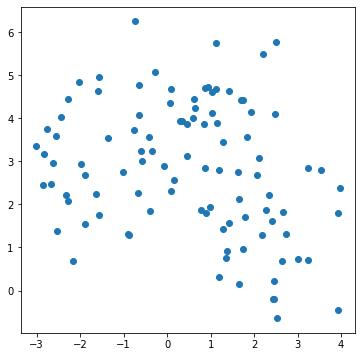

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


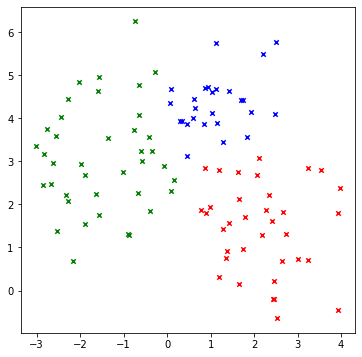

In [24]:
model = GMM(100, 3)
model.plot_data()
model.fit()
model.predict()
model.plot_data()

We now see how a GMM algorithm works.

### 3.2. Implementation using SciKit-Learn

As the simple from scratch GMM works, and now that we have a better grasp on the different steps involved to fit the model, we can implement one using the SciKit-Learn library. 

As such, we go back to our Fashion-MNIST dataset.

1. We set our hyperparameters:

In [25]:
# Number of components we want to implement our model with
# We set it to match the number of classes in the Fashion-MNIST dataset
n_components = 10

# We indicate we want the model will not go over 100 iterations
max_iter = 100

2. We declare our model:

In [26]:
model = GaussianMixture(n_components=n_components, 
                        max_iter=max_iter, 
                        verbose=0,
                        random_state=0).fit(x_train)

3. We predict labels on our test dataset using the resulting trained model:

In [27]:
label_predictions = model.predict(x_test)

4. We output our resulting metrics:

In [28]:
gmm_h_score = homogeneity_score(y_test, label_predictions)
gmm_v_score = v_measure_score(y_test, label_predictions)
gmm_s_score = silhouette_score(x_test, label_predictions)

print(gmm_h_score,gmm_v_score,gmm_s_score)

0.5480860311853569 0.5551891023091904 0.08121377084408062


<u>See our detailed observations below.</u>

### 3.3. Observations

We visualize the resulting clustering on our test set.

Each row presents a trio of pictures that were assigned to the same cluster.

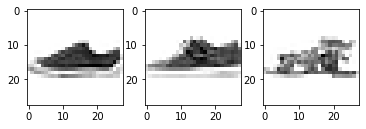

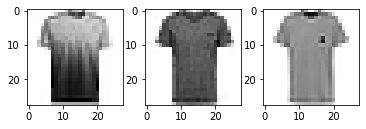

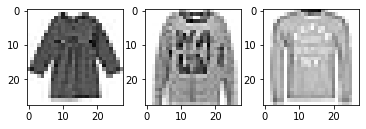

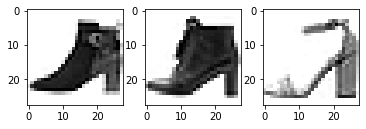

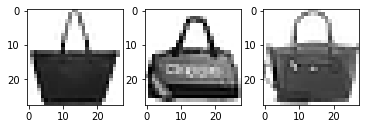

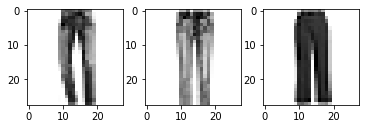

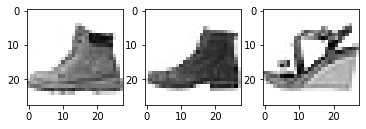

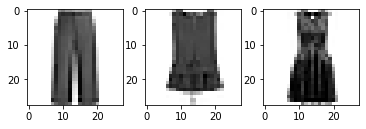

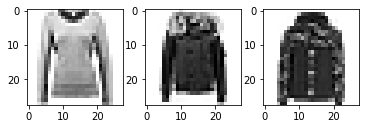

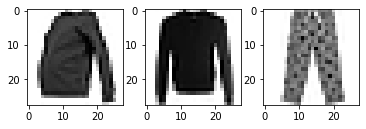

In [29]:
label_number = 10

cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(label_predictions):
    for n in range(label_number):
        if label == n: cluster_index[n].append(i)
        else: continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(6,6));
    clust = j 
    num = 10
    for i in range(1,4):
        plt.subplot(3, 3, i) 
        plt.imshow(x_test_origin[cluster_index[clust][i+20]], 
                   cmap = plt.cm.binary);

plt.show()

To provide a better view of what is happening, we visualize the repartition of the test set's items between each clusters.

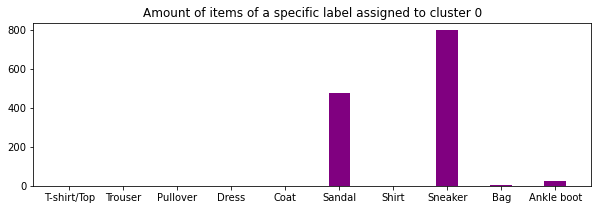

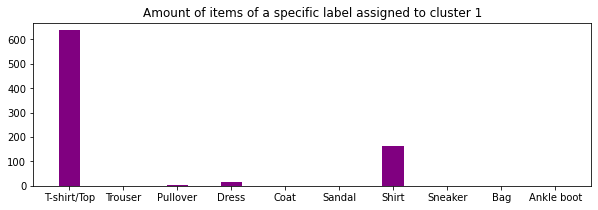

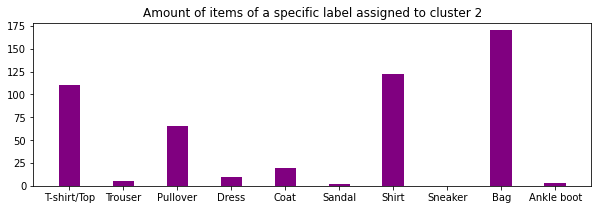

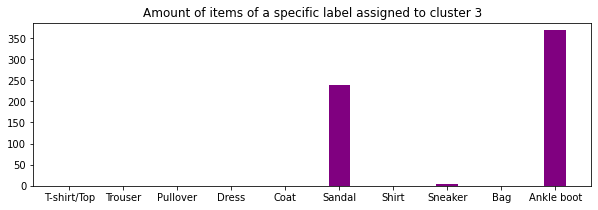

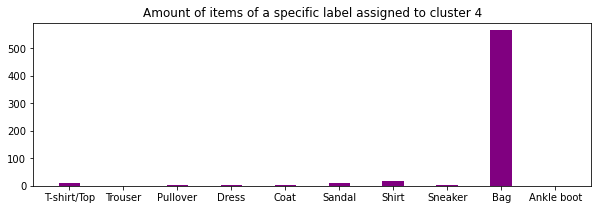

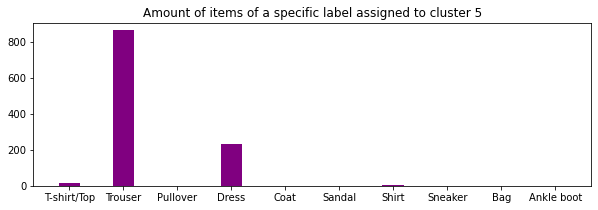

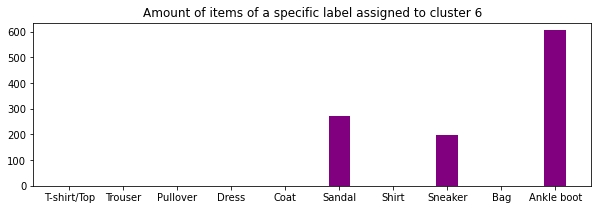

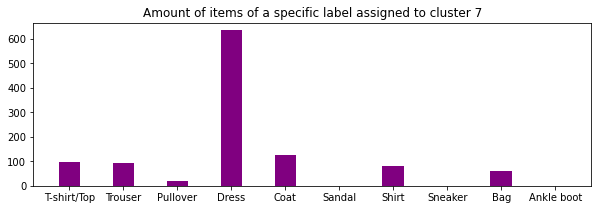

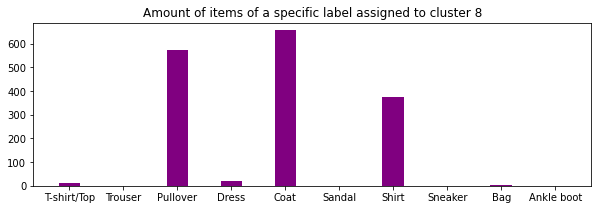

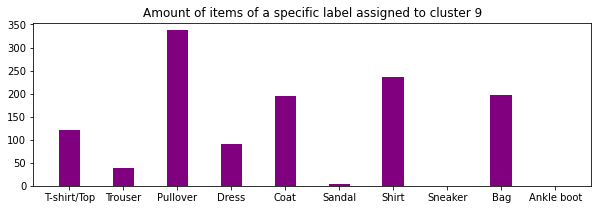

In [30]:
clusters={}
for i in range(10):
    clusters[i]=[0]*10

for index, item in enumerate(label_predictions):
    clusters[item][y_test[index]] += 1

for i in range(len(clusters)):
    fig = plt.figure(figsize=(10,3))
    plt.bar(labelNames, clusters[i], color="purple", width=0.4)
    plt.title(f"Amount of items of a specific label assigned to cluster {i}")
    plt.show()

Finally, we look into reducing the dimensionality of our dataset to 3, and produce a 3-d visualization of the clustering. 

The goal is to see if we can find patterns.

In [31]:
pca = decomposition.PCA(n_components = 3)
x_test_viz = StandardScaler().fit_transform(x_test)
x_test_viz = pca.fit_transform(x_test_viz)

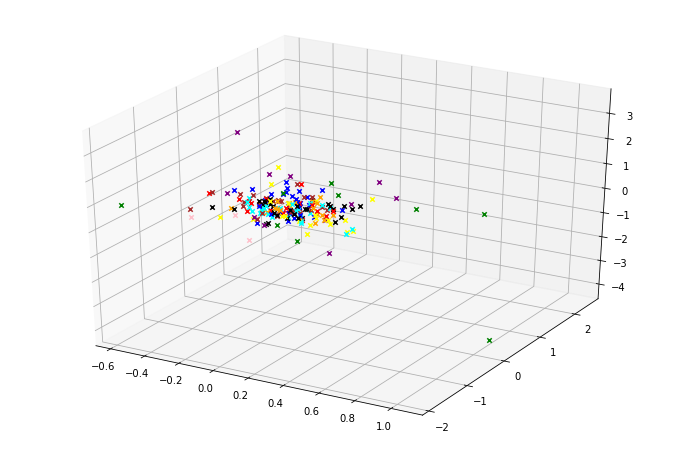

In [32]:
colors = ["blue","red","green","pink","purple",
          "cyan","yellow","orange","black","brown"]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for index, item in enumerate(x_test_viz[:200]):
    ax.scatter(item[0], 
               item[1], 
               item[2], 
               marker="x", 
               color = colors[label_predictions[index]])

plt.show()

**<u>Summary of observations:</u>**

<hr> 
<span style="color:green">The above visualizations highlight a few key behaviors:
    
> 1. GMM is able to distinguish **ankle boots**, **sandals** and **sneakers** (clusters 0, 3, and 6) from the rest of the dataset
>
> 2. GMM seems **marginally worse than KMeans with regards to bags** as, while cluster 4 specifically focuses on bags, we see that a non-negligeable amount of bags were assigned to the clusters 2 and 9 with a lot of top clothes
>
> 3. Like KMeans, GMM **struggles identifying trousers from dresses** albeit marginally less so at first glance (cluster 5)
>
> 4. Like KMeans, GMM **struggles identifying all top clothes from each other** (clusters 1, 7, 8, and 9)

We obtained a **homogeneity score of c. 0.54**, a **v-measure score of c. 0.56**, and a **silhouette score of c. 0.08**.
    
**As such, we can confidently say that the GMM algorithm is able to distinguish larger granularities of clothes (top, bag, shoes) than the ones provided by the Fashion-MNIST dataset.**

<hr>

## 4. Comparing the results of both KMeans and GMM

### 4.1. Comparison

To compare the results between KMeans and GMM, we plot the different scores we retrieved from each models.

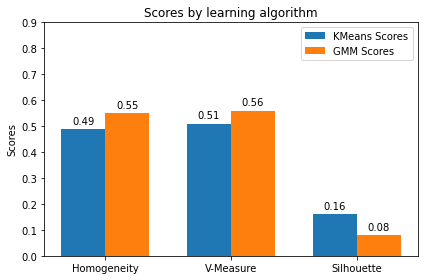

In [42]:
gmm_scores = list(map(lambda x: round(x,2), 
                      [gmm_h_score, gmm_v_score, gmm_s_score]))
kmeans_scores = list(map(lambda x: round(x,2), 
                         [kmeans_h_score, kmeans_v_score, kmeans_s_score]))
labels = ['Homogeneity', 'V-Measure', 'Silhouette']

x = np.arange(0, len(labels))  # the label locations
y = np.arange(0, 1,0.1) # the y-axis labels
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, kmeans_scores, width, label='KMeans Scores')
rects2 = ax.bar(x + width/2, gmm_scores, width, label='GMM Scores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by learning algorithm')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**<u>Conclusion:</u>**

<hr><span style="color:green">

**GMM marginally improves improves clustering performance on the Fashion-MNIST dataset compared to the KMeans algorithm**. 
    
However, we observe that **we have a lower silhouette score with the GMM algorithm**, indicating that the algorithm tends to lead to an increasing amount of overlapping clusters.

<hr>

### 4.2. Other Explorations: Trying out MaxPooling and a Sobel Filter instead of PCA

As we have used PCA in order to reduce the dimensionality of the dataset, we can also test out other ways to pre-process the Fashion-MNIST dataset, including:

- **MaxPooling**:The goal is to calculate the maximum value for each patch of the feature map.

- **Sobel Filtering**: Sobel filtering aims at finding edges on a picture.

The goal here is to go back to the raw training and test sets and apply those two different operations instead of our previous preprocessing and see what results we can yield.

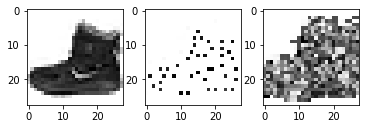

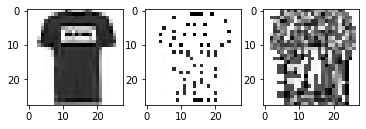

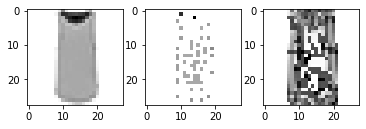

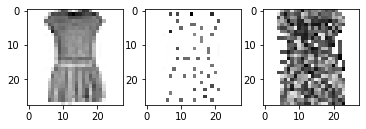

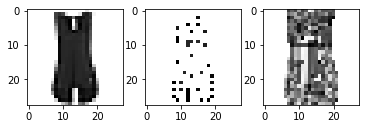

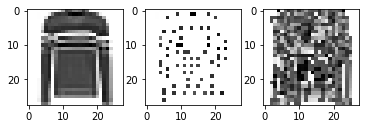

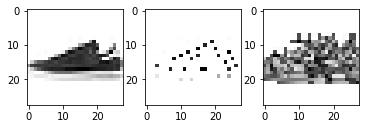

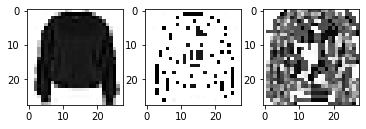

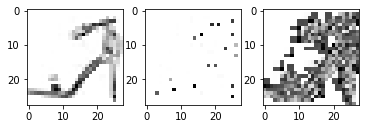

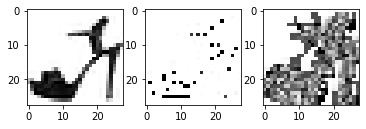

In [44]:
def max_pool(picture):
    """
    (3,3) kernel max-pooling of a picture with stride and padding 1, 
    with normalization
    """
    return picture*(picture == maximum_filter(picture,
                                              footprint=np.ones((3,3))))/255.

def sobel_filter(picture):
    """
    Sobel filtering of a picture along the x and y axes, with normalization
    """
    dx = ndimage.sobel(pic, 0)  # horizontal derivative
    dy = ndimage.sobel(pic, 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize
    return np.asarray(mag, dtype=np.float32)/255.
            
for i in range(10):
    pic = x_train_origin[i]
    sobel_pic = sobel_filter(pic)
    maxpooled_pic = max_pool(pic)
    plt.figure(figsize=(6,6))
    plt.subplot(3, 3, 1); plt.imshow(pic, cmap = plt.cm.binary)
    plt.subplot(3, 3, 2); plt.imshow(maxpooled_pic, cmap = plt.cm.binary)
    plt.subplot(3, 3, 3); plt.imshow(sobel_pic, cmap = plt.cm.binary)

plt.show()

1. Training and test sets preprocessing using the sobel and maxpool functions

In [35]:
def sobel_fMNIST(dataset):
    return np.array(list(map(sobel_filter, dataset))).reshape(len(dataset), 784)

def maxpool_fMNIST(dataset):
    return np.array(list(map(max_pool, dataset))).reshape(len(dataset), 784)

x_train_sobel = sobel_fMNIST(x_train_origin)
x_train_maxpool = maxpool_fMNIST(x_train_origin)
x_test_sobel = sobel_fMNIST(x_test_origin)
x_test_maxpool = maxpool_fMNIST(x_test_origin)

print(x_train_sobel.shape, x_train_maxpool.shape, 
      x_test_sobel.shape, x_test_maxpool.shape)

(60000, 784) (60000, 784) (10000, 784) (10000, 784)


2. Declaring our models

In [36]:
def run_kmeans(x_train, x_test, y_test):
    model = KMeans(n_clusters=10, random_state=0).fit(x_train)
    label_predictions = model.predict(x_test)
    kmeans_h_score = homogeneity_score(y_test, label_predictions)
    kmeans_v_score = v_measure_score(y_test, label_predictions)
    print(kmeans_h_score, kmeans_v_score)

In [37]:
def run_gmm(x_train, x_test, y_test):
    model = GaussianMixture(n_components=10, random_state=0).fit(x_train)
    label_predictions = model.predict(x_test)
    kmeans_h_score = homogeneity_score(y_test, label_predictions)
    kmeans_v_score = v_measure_score(y_test, label_predictions)
    print(kmeans_h_score, kmeans_v_score)

3. Running our models

In [38]:
run_gmm(x_train_maxpool, x_test_maxpool, y_test)

0.37893416779996025 0.42943222404667425


In [39]:
run_kmeans(x_train_maxpool, x_test_maxpool, y_test)

0.367940095375142 0.3896772340322883


In [40]:
run_gmm(x_train_sobel, x_test_sobel, y_test)

0.0 0.0


In [41]:
run_kmeans(x_train_sobel, x_test_sobel, y_test)

0.0 0.0


**<u>Summary of observations:</u>**

The results are definitely worse. 

**Maxpooling instead of our previous preprocessing shows lower results for the homogeneity and v measure scores for both the KMeans and GMM implementations**. 

Meanwhile, training KMeans and GMM on the sobel filtered data yields scores of 0. It indicates either that the filtering erased some of the differentiable features between each items in the set, or that something is wrong with the sobel implementation.

## 5. Exploring the parameters of GMM

To explore the impact of different hyperparameters on the GMM algorithm, we will implement our own version of a gridsearch function to iterate over the following hyperparameters:

| Hyperparameter | Variables |
|---|---|
| n_components  | 10 to 40 components by steps of 2 (i.e. 10, 12, 14, ..., 40) |
| covariance types\*  | full, tied, diagonal and spherical |
| Initialization  | kmeans, random |

\* ‘**full**’ indicates that each component has its own general covariance matrix, ‘**tied**’ that all components share the same general covariance matrix, ‘**diag**’ that each component has its own diagonal covariance matrix, and  ‘**spherical**’ that each component has its own single variance.

Such a gridsearch will yield **128 different models** that we will be able to compare using the metrics we have introduced and used in the previous parts: homogeneity, v-measure, and silhouette.

In [34]:
class GridSearch():
    def __init__(self, hyperparameters):
        """
        Initializes our gridsearch object.
        """
        self.hyperparameters = hyperparameters
        self.training_results = {}
    
    def fit(self, x_train, y_train):
        """
        Fits a GMM algorithm given the set of hyperparameters used during 
        initializations.
        """
        model_number = 0
        for component in hyperparameters["n_components"]:
            for covariance in hyperparameters["covariance_type"]:
                for param in hyperparameters["init_params"]:
                    model_number += 1
                    model = GaussianMixture(n_components=component, 
                                                 covariance_type=covariance,
                                                 init_params=param,
                                                 random_state=0)
                    model.fit(x_train)
                    h_score, v_score, sil_score = self.scoring(model, 
                                                               x_train, 
                                                               y_train)
                    print(f"GMM #{model_number} trained with {component} " + 
                          f"components, cov. type {covariance}, " +
                          f"and a {param} parameter initialization, which " + 
                          "yielded homogeneity, v_measure and silhouette " + 
                          f"scores of {h_score}, {v_score} and " + 
                          f"{sil_score} resp.\n")
                    self.training_results[model_number] = {
                        "n_components":component, 
                        "covariance_type":covariance, 
                        "model": model,
                        "homogeneity_score": h_score,
                        "v_measure_score": v_score}
        
        return self.training_results
        
    def scoring(self, model, X, y):
        """
        Scoring function that returns the homogeneity, v-measure and 
        silhouette score
        of a given model
        """
        y_pred = model.predict(X)
        v_score = v_measure_score(y, y_pred)
        h_score = homogeneity_score(y, y_pred)
        sil_score = silhouette_score(X, y_pred, metric='euclidean')
        return h_score, v_score, sil_score
    
    def predict(self, model_number, x_test, y_test):
        """
        Predicts the results on a dataset (here test set) given a model number.
        """
        model = self.training_results[model_number]["model"]
        h_score, v_score, sil_score = self.scoring(model, x_test, y_test)
        print(f"GMM #{model_number} yielded homogeneity, " + 
              "v_measure and silhouette scores "+
              f"of {h_score}, {v_score} and {sil_score} resp. on the test set")
        return model.predict(x_test)

In [35]:
hyperparameters = {"n_components":range(10, 41, 2),
                   "covariance_type":["full", "tied", "diag", "spherical"],
                   "init_params":["kmeans", "random"]}

grid_search = GridSearch(hyperparameters)

*Please find the summary of the best models resulting from this gridsearch at the end of this document*.

In [36]:
results = grid_search.fit(x_train, y_train)

GMM #1 trained with 10 components, cov. type full, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5511592078344985, 0.5584791747996576 and 0.0815661328826588 resp.

GMM #2 trained with 10 components, cov. type full, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.508523389964617, 0.5338744662137322 and 0.09199440509517363 resp.

GMM #3 trained with 10 components, cov. type tied, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5758313952528333, 0.5902039215949794 and 0.0930896303712398 resp.

GMM #4 trained with 10 components, cov. type tied, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.051513090460491066, 0.051757989351417316 and -0.03797984175168568 resp.

GMM #5 trained with 10 components, cov. type diag, and a kmeans parameter initialization, which yielded homoge

GMM #38 trained with 18 components, cov. type diag, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.466838361505079, 0.42617628832486365 and -0.027702707367792196 resp.

GMM #39 trained with 18 components, cov. type spherical, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5940584697782718, 0.5330566534933096 and 0.10828825285894891 resp.

GMM #40 trained with 18 components, cov. type spherical, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5851476739980825, 0.5228970625057223 and 0.10027891010757325 resp.

GMM #41 trained with 20 components, cov. type full, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5904178344426593, 0.5312789590369091 and 0.03294134578626384 resp.

GMM #42 trained with 20 components, cov. type full, and a random parameter initialization, which

GMM #75 trained with 28 components, cov. type tied, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.638347240776981, 0.547321075331773 and 0.07070281945073202 resp.

GMM #76 trained with 28 components, cov. type tied, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.09894255795218472, 0.08173707705315729 and -0.06524970441158875 resp.

GMM #77 trained with 28 components, cov. type diag, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5826772968456823, 0.4857922697561558 and 0.0024134141399392317 resp.

GMM #78 trained with 28 components, cov. type diag, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5701768132682518, 0.4768620686082618 and 0.003735806325893379 resp.

GMM #79 trained with 28 components, cov. type spherical, and a kmeans parameter initialization, which yi

GMM #112 trained with 36 components, cov. type spherical, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.6396633426308849, 0.5043550197153982 and 0.0764653587834188 resp.

GMM #113 trained with 38 components, cov. type full, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.6526586574149544, 0.5273375845531014 and 0.001828516530424049 resp.

GMM #114 trained with 38 components, cov. type full, and a random parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.5927073937731158, 0.5212844803189792 and 0.03764787556562273 resp.

GMM #115 trained with 38 components, cov. type tied, and a kmeans parameter initialization, which yielded homogeneity, v_measure and silhouette scores of 0.64484644735645, 0.5262162042580933 and 0.07000907665555685 resp.

GMM #116 trained with 38 components, cov. type tied, and a random parameter initialization, which yie

In [37]:
for i in range(1, 129):
    y_pred = grid_search.predict(i, x_test, y_test)

GMM #1 yielded homogeneity, v_measure and silhouette scores of 0.5492297436734518, 0.5563060612807291 and 0.08098997682317997 resp. on the test set
GMM #2 yielded homogeneity, v_measure and silhouette scores of 0.5060642316896842, 0.5322830070420804 and 0.0895828290812694 resp. on the test set
GMM #3 yielded homogeneity, v_measure and silhouette scores of 0.5728075097533654, 0.5872633169349237 and 0.09267037477070339 resp. on the test set
GMM #4 yielded homogeneity, v_measure and silhouette scores of 0.054115982523730455, 0.054385031772762424 and -0.03737284065814241 resp. on the test set
GMM #5 yielded homogeneity, v_measure and silhouette scores of 0.4221928611689869, 0.4363229458671653 and 0.03456878587517899 resp. on the test set
GMM #6 yielded homogeneity, v_measure and silhouette scores of 0.41140280811971053, 0.42476908404433816 and 0.020868564071252853 resp. on the test set
GMM #7 yielded homogeneity, v_measure and silhouette scores of 0.4829051828580381, 0.48734775589756274 an

GMM #56 yielded homogeneity, v_measure and silhouette scores of 0.6007459038012954, 0.5167395457771872 and 0.08520958156559774 resp. on the test set
GMM #57 yielded homogeneity, v_measure and silhouette scores of 0.6145865438511855, 0.5360038255057448 and 0.030112409215559473 resp. on the test set
GMM #58 yielded homogeneity, v_measure and silhouette scores of 0.5847166812960344, 0.5407299449614407 and 0.05861808510574932 resp. on the test set
GMM #59 yielded homogeneity, v_measure and silhouette scores of 0.6417470600130685, 0.562844999518346 and 0.0764870334283554 resp. on the test set
GMM #60 yielded homogeneity, v_measure and silhouette scores of 0.09158524370260444, 0.07760150384669773 and -0.07481179529345788 resp. on the test set
GMM #61 yielded homogeneity, v_measure and silhouette scores of 0.5708228212101388, 0.4915607345066861 and 0.006629525100266338 resp. on the test set
GMM #62 yielded homogeneity, v_measure and silhouette scores of 0.5708057698169106, 0.48951964445709856

GMM #111 yielded homogeneity, v_measure and silhouette scores of 0.6425632062550398, 0.5064668649126424 and 0.07035656931062909 resp. on the test set
GMM #112 yielded homogeneity, v_measure and silhouette scores of 0.6408963321152251, 0.5052708323758979 and 0.0742571065132989 resp. on the test set
GMM #113 yielded homogeneity, v_measure and silhouette scores of 0.6495528145475682, 0.5274040078974358 and 0.007269445398636043 resp. on the test set
GMM #114 yielded homogeneity, v_measure and silhouette scores of 0.5966356366328227, 0.532036309586 and 0.039455995825520826 resp. on the test set
GMM #115 yielded homogeneity, v_measure and silhouette scores of 0.646158951848421, 0.5274626810079904 and 0.0662786463909319 resp. on the test set
GMM #116 yielded homogeneity, v_measure and silhouette scores of 0.11029044674503394, 0.08678746229721276 and -0.08598871110388136 resp. on the test set
GMM #117 yielded homogeneity, v_measure and silhouette scores of 0.6157435068327551, 0.487363550853741

After training and testing over 128 GMM models by varying the hyperparameters, we find that the best results are achieved here:

| Model  number | k components | Covariance parameter | Initialization parameter |
|---|---|---|---|
| 11  | 12 | tied | kmeans |
| 19  | 14 | tied | kmeans |
| 35  | 18 | tied | kmeans |
| 59  | 24 | tied | kmeans |
| 91  | 32 | tied | kmeans |
| 121 | 40 | full | kmeans |

| Model  number | Homogeneity score  (train set) | V-measure score (train set) | Silhouette score (train set) | Homogeneity score  (test set) | V-measure score (test set) | Silhouette score (test set) |
|---|---|---|---|---|---|---|
| 11  | 0.624 | 0.612 | 0.102 | 0.618 | 0.606 | 0.099 |
| 19  | 0.634 | 0.608 | 0.101 | 0.633 | 0.608 | 0.098 |
| 35  | 0.637 | 0.589 | 0.093 | 0.637 | 0.589 | 0.091 |
| 59  | 0.641 | 0.562 | 0.078 | 0.642 | 0.563 | 0.076 |
| 91  | 0.644 | 0.541 | 0.069 | 0.642 | 0.541 | 0.066 |
| 121 | 0.671 | 0.537 | 0.010 | 0.669 | 0.537 | 0.001 |

In conclusion. It seems that the best results (a homogeneity and v-measure scores above 0.6 and a silhouette score around 0.1) are obtained while using between **12 and 24 components**, with a **kmeans initialization** and a **tied covariance matrix** (i.e. all components share the same general covariance matrix).

As we increase the number of component, the silhouette score seems to drop towards 0, indicating that mixtures are increasingly overlapping each other.

## 6. References used in this exercise

**Dataset information**:

- https://www.kaggle.com/c/ttic-31020-hw5-fmnist-gmm/leaderboard

**Kmeans and GMM information**:

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

- https://brilliant.org/wiki/gaussian-mixture-model/

- https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566

- https://ukdevguy.com/k-means-algorithm-for-clustering/

**Metrics information**:

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html

- https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/